# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publicly available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display  # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-muted')

# Reset the matplotlib style without restarting the notebook
# import matplotlib as mpl
# mpl.rcdefaults()

# Load the Census dataset
data = pd.read_csv("census.csv")
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
data['income'].value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

In [2]:
n_records = len(data)  # data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

print("Total number of records: {:,}".format(n_records))
print("Individuals making more than $50,000: {:,}".format(n_greater_50k))
print("Individuals making at most $50,000: {:,}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45,222
Individuals making more than $50,000: 11,208
Individuals making at most $50,000: 34,014
Percentage of individuals making more than $50,000: 24.78%


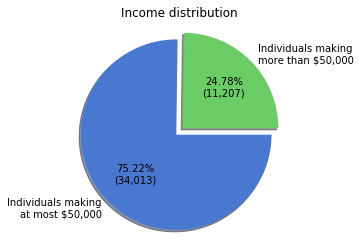

In [3]:
def income_wedge_label(pct):
    absolute = int(pct/100. * n_records)
    return '{:.2f}%\n({:,})'.format(pct, absolute)

pie_labels = ['Individuals making\nat most $50,000', 'Individuals making\nmore than $50,000']
plt.pie([n_at_most_50k, n_greater_50k], labels=pie_labels,
        explode=[0.1, 0], shadow=True, counterclock=False, 
        autopct=lambda pct: income_wedge_label(pct))
plt.axis('equal')  # Draw the pie chart as a circle
plt.title('Income distribution')
plt.show()

### Featureset Exploration

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education_level**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [3]:
numerical_features = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']
categorical_features = ['workclass', 'education_level', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']

### Distributions of continuous features

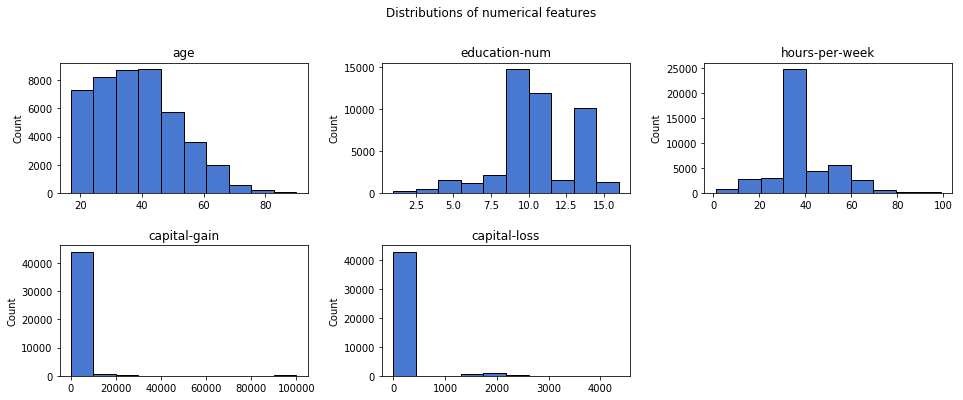

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(16, 6))
fig.suptitle('Distributions of numerical features')
plt.subplots_adjust(top=0.85, wspace=0.3, hspace=0.4)
axs[1, 2].remove()

for i, col in enumerate(numerical_features):
    ax = axs[i//3, i%3]
    ax.hist(data[col], edgecolor='k')
    ax.set_title(col)
    ax.set_ylabel('Count')
plt.show()

### Categorical features
- Almost all individuals (91%) are from the United States, so plotting all countries on the same bar chart would make the other countries barely visible. Plotting the top 5 other countries separately should give an overview of where the other individuals are coming from.

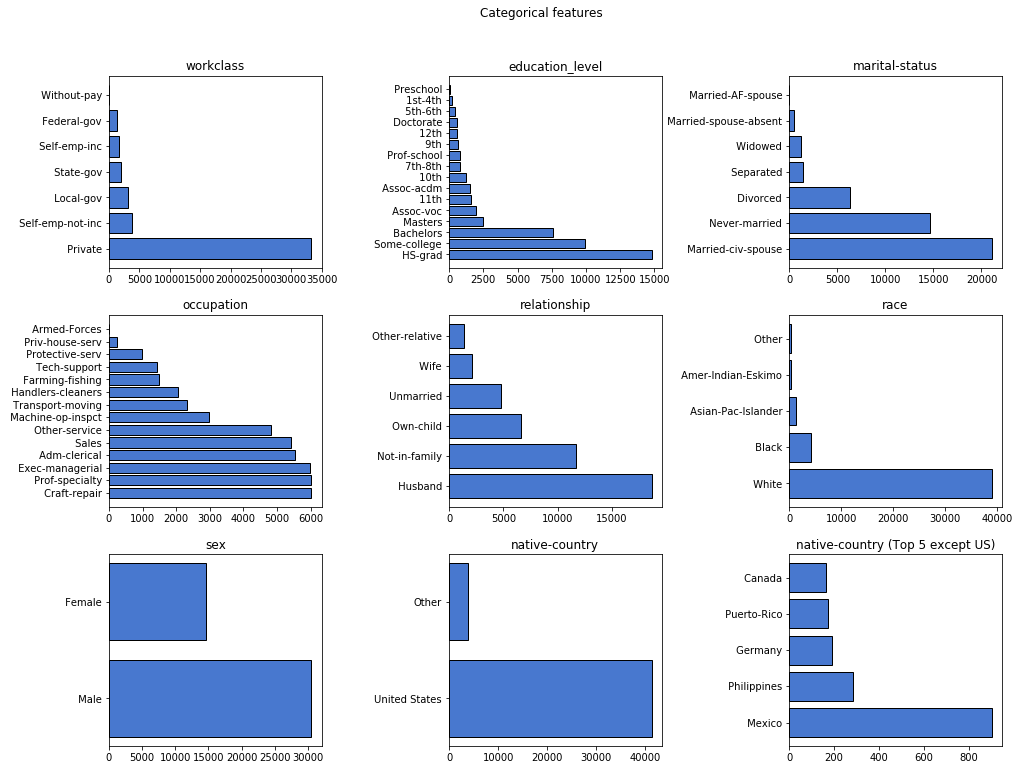

In [6]:
# Calculate the number of individuals that are not from the US
# and determine the top 5 countries (except the US)
other_native_countries = data[data['native-country'] != ' United-States']['native-country']
n_from_other_countries = len(other_native_countries)
n_from_us = n_records - n_from_other_countries
top5_countries_except_us = other_native_countries.value_counts().nlargest(5)

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Categorical features')
plt.subplots_adjust(top=0.9, wspace=0.6, hspace=0.25)

# Plot the "native-country" feature
axs[2, 1].barh(['United States', 'Other'], [n_from_us, n_from_other_countries], edgecolor='k')
axs[2, 1].set_title('native-country')
axs[2, 2].barh(top5_countries_except_us.index.values, top5_countries_except_us.values, edgecolor='k')
axs[2, 2].set_title('native-country (Top 5 except US)')

# Plot the other categorical features
for i, col in enumerate(categorical_features[:-1]):
    labels = data[col].value_counts().index.values
    values = data[col].value_counts().values
    ax = axs[i//3, i%3]
    ax.barh(labels, values, edgecolor='k')
    ax.set_title(col)
plt.show()

----

## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

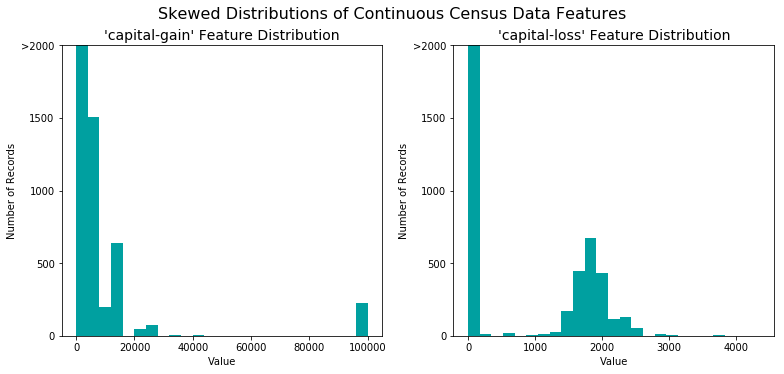

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

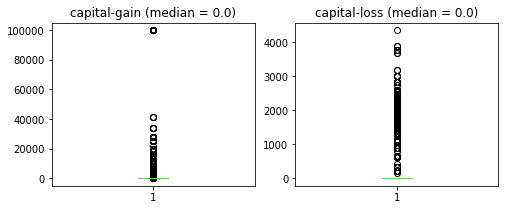

In [8]:
capital_gain_median = np.median(data['capital-gain'])
capital_loss_median = np.median(data['capital-loss'])

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].boxplot(data['capital-gain'])
axs[0].set_title('capital-gain (median = {})'.format(capital_gain_median))
axs[1].boxplot(data['capital-loss'])
axs[1].set_title('capital-loss (median = {})'.format(capital_loss_median))    
plt.show()

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

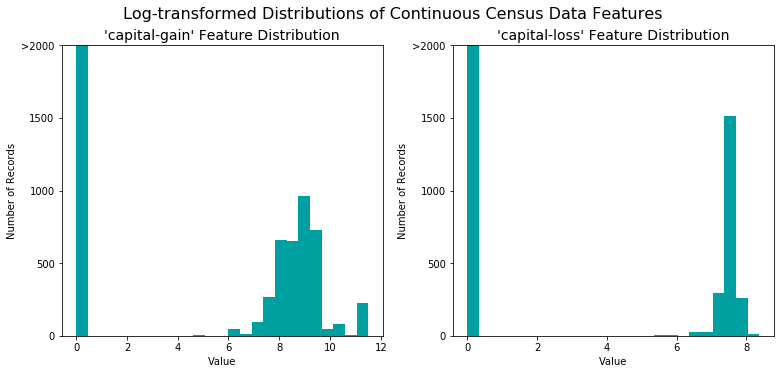

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = features_raw.copy()  # pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()  # default range = (0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

display(features_log_minmax_transform.head(5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

features_final = pd.get_dummies(features_log_minmax_transform)
oh_encoded_cols = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(oh_encoded_cols)))
# print(oh_encoded_cols)
# features_final.head()

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

print("Training set has {:,} samples.".format(X_train.shape[0]))
print("Testing set has {:,} samples.".format(X_test.shape[0]))

Training set has 36,177 samples.
Testing set has 9,045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall (sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [9]:
'''
The naive model always makes positive predictions
(it always predicts that an individual makes more than $50,000)
'''

# Determine the number of True Positives by counting
# how many individuals actually make more than $50,000
# (these individuals have an encoded value of 1 in income column)
naive_tp = np.sum(income)
naive_fp = income.count() - naive_tp

# The naive model never makes a negative prediction
# (it never predicts that a person makes less than $50,000)
naive_tn = 0
naive_fn = 0

accuracy = (naive_tp + naive_tn) / income.count()
recall = naive_tp / (naive_tp + naive_fn)
precision = naive_tp / (naive_tp + naive_fp)

# Calculate the F-score for beta = 0.5 because precision is more important
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

print('Naive Predictor performance:')
print('Accuracy:\t{:.4f}'.format(accuracy))
print('Recall: \t{:.4f}'.format(recall))
print('Precision:\t{:.4f}'.format(precision))
print('F-score:\t{:.4f}'.format(fscore))

Naive Predictor performance:
Accuracy:	0.2478
Recall: 	1.0000
Precision:	0.2478
F-score:	0.2917


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer:**

**Important notes about our use case:**
- It's a binary classification problem
- It has a skewed distribution of classes: only 25% of individuals earn more than $50,000

### Selected learning models

**1. Support Vector Machines**
- **Real-world application**
  - The SVM algorithm has been successfully used in the medical field to identify genes that are relevant to cancer diagnosis. [SVMGS] A major challenge of this problem is given by the high number of features (thousands of gene expression values per experiment) and low number of samples (a few dozen experiments). The SVM manages to overcome this challenge and obtains 98% accuracy in a colon cancer dataset. This type of application enables researchers to better understand cancer and to confirm their discoveries.
- **Strengths**
  - Can handle problems where data is not linearly separable by using the kernel trick.
  - The solution is guaranteed to be the global minimum. [ADMT]
  - High performance in many real-world classification problems, such as medical diagnosis, face recognition and image processing. [ADMT]
- **Weaknesses**
  - Sensitive to outliers in the training set, as they cause the separating hyperplane to move away from the optimum one. [SVMBRK]
  - Requires a lot of computational resources to train on large datasets. [ESL]
  - In practice, it's difficult to find optimal kernel function parameters. [ADMT]
  - In its standard form, the SVM algorithm performs poorly in the presence of many irrelevant features. [SVMFT]
- **Applicability to our problem**
  - SVM is a solid candidate due to its wide real-world success in binary classification problems, including those with skewed classes distributions.

**2. AdaBoost with Decision Trees**
- **Real-world application**
  - AdaBoost has been among the winners of the Yahoo! Learning to Rank Challenge. [YAHOO] It was used to learn a ranking function that ranks documents matching a query, according to their relevance. This ranking function is critical to search engines and it must be tuned in order to improve the search results offered to the end-users.
- **Strengths**
  - Leo Breiman called AdaBoost with trees the “best off-the-shelf classifier in the world". [ESL]
  - Tends not to overfit, even after hundreds of iterations. [AB]
  - Can be used with any learning algorithm.
  - Easy to tune as it has only one hyperparameter - the number of iterations.
- **Weaknesses**
  - Sensitive to noise and outliers. [RF] Since the algorithm places more and more emphasis on misclassified points, with each iteration, it will focus on fitting the outliers and it will lead to an overfitted model. One way to minimize the chance of overfitting is to stop early. [ESL]
  - The original algorithm has poor performance on multi-class problems. T. Hastie et. al [ABMC] have addressed this issue and proposed an extended version with multi-class support in the SAMME algorithm (this is the one implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)).
  - Poor performance in problems with overlapping class distributions. [ESL]
- **Applicability to our problem**
  - Our binary classification task is a great match for AdaBoost since this is the kind of problem it was developed for. Moreover, it has great out-of-the-box performance and requires little tuning.


**3. Random Forests**
- **Real-world application**
  - Abu-Nimeh et. al [RFPH] used Random Forests to detect phising e-mails with an error rate of 7.72%. They transformed the e-mails using the Bag-of-Words model and trained a Random Forests model on the 43 most frequently used words.
  - In the past decade, Random Forests have become the standard tool for binary classification problems in Bioinformatics. [RFBIO]
- **Strengths**
  - Great out-of-the-box performance on binary classification problems. [RFBIO]
  - They are highly unlikely to overfit if sufficient trees are used. [RF]
  - They are robust with respect to outliers and noise. [ESL]
  - They can handle high-dimensional datasets because each tree is grown using only a subset of the features. [RF] This also makes them fast to train on datasets with a large number of features.
  - They can handle both numerical and categorical variables, without any preprocessing. [RF]
- **Weaknesses**
  - They have poor performance in the presence of many irrelevant features because the chance to select relevant features at each split is small. [ESL]
  - It's difficult to interpret the predicted results, although there are ways to measure feature importance. [RF]
- **Applicability to our problem**
  - It usually has great performance in binary classification problems and it's less sensitive to noise than AdaBoost. [RF]
  - It's also faster to train than AdaBoost because each tree is grown using only a subset of the features, unlike AdaBoost which uses all features. [RF] Moreover, Random Forests can be trained in parallel because each tree is independent of the others, whereas AdaBoost must run sequentially.


**References:**

[AB] *Freund, Y., & Schapire, R. E. (1997). A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting. Journal of Computer and System Sciences, 55(1), 119–139.*

[ABMC] *Hastie, Trevor, et al. "Multi-class adaboost." Statistics and its Interface 2.3 (2009): 349-360.*

[ADMT] *Olson, D. L., & Delen, D. (2008). Advanced Data Mining Techniques. Springer Science & Business Media.*

[ESL] *Friedman, J., Hastie, T., & Tibshirani, R. (2001). The Elements of Statistical Learning: Data Mining, Inference and Prediction (Second Edi, Vol. 1). Springer series in statistics New York.*

[RF] *Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32.*

[SVMBRK] *Kanamori, T., Fujiwara, S., & Takeda, A. (2017). Breakdown point of robust support vector machines. Entropy, 19(2).*

[RFBIO] *Couronné, R., Probst, P., & Boulesteix, A.-L. (2018). Random forest versus logistic regression: a large-scale benchmark experiment. BMC Bioinformatics, 19(1), 270.*

[RFPH] *Abu-Nimeh, S., Nappa, D., Wang, X., & Nair, S. (2007, October). A comparison of machine learning techniques for phishing detection. In Proceedings of the anti-phishing working groups 2nd annual eCrime researchers summit (pp. 60-69). ACM.*

[SVMGS] *Guyon, I., Weston, J., Barnhill, S., & Vapnik, V. (2002). Gene Selection for Cancer Classification using Support Vector Machines. Machine Learning, 46(1/3), 389–422.*

[SVMFT] *Weston, J., Mukherjee, S., Chapelle, O., Pontil, M., Poggio, T., & Vapnik, V. (2001). Feature selection for SVMs. In Advances in neural information processing systems (pp. 668–674).*

[YAHOO] *Chapelle, O., & Chang, Y. (2011, January). Yahoo! learning to rank challenge overview. In Proceedings of the learning to rank challenge (pp. 1-24).*

---

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    Inputs:
       - learner: Learning algorithm to be trained and predicted on
       - sample_size (integer): Size of samples to be drawn from training set
       - X_train, y_train:  Training set
       - X_test, y_test:  Testing set
    '''
    
    print('Training {} on {:6,d} samples... '
          .format(learner.__class__.__name__, sample_size), end='')
    
    results = {}
    
    # Fit the learner to the sample training data
    start_time = time()
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    results['train_time'] = time() - start_time
    
    # Make predictions on the sample testing data
    # and on the first 300 training samples
    start_time = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    results['pred_time'] = time() - start_time
    
    # Calculate accuracy and F-score of the learner's predictions
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
      
    print('DONE! (Train: {:.2f}s; Predict: {:.2f}s)'
          .format(results['train_time'], results['pred_time']))
    
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

In [100]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize models
clf_A = SVC(random_state=14)
clf_B = AdaBoostClassifier(random_state=14)
clf_C = RandomForestClassifier(random_state=14)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Evaluate the performance of each learner on all three sample sizes
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples,
                                             X_train, y_train, X_test, y_test)

Training SVC on    361 samples... 

/home/ovidiu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


DONE! (Train: 0.02s; Predict: 0.32s)
Training SVC on  3,617 samples... DONE! (Train: 1.23s; Predict: 2.48s)
Training SVC on 36,177 samples... DONE! (Train: 130.93s; Predict: 22.10s)
Training AdaBoostClassifier on    361 samples... DONE! (Train: 0.07s; Predict: 0.07s)
Training AdaBoostClassifier on  3,617 samples... DONE! (Train: 0.20s; Predict: 0.06s)
Training AdaBoostClassifier on 36,177 samples... DONE! (Train: 1.44s; Predict: 0.06s)
Training RandomForestClassifier on    361 samples... DONE! (Train: 0.01s; Predict: 0.02s)
Training RandomForestClassifier on  3,617 samples... DONE! (Train: 0.04s; Predict: 0.02s)
Training RandomForestClassifier on 36,177 samples... DONE! (Train: 0.58s; Predict: 0.03s)


In [116]:
print('F-scores on testing set:')
for clf, rs in results.items():
    print('{:.4f} - {}'.format(rs[2]['f_test'], clf))

F-scores on testing set:
0.6745 - SVC
0.7246 - AdaBoostClassifier
0.6762 - RandomForestClassifier


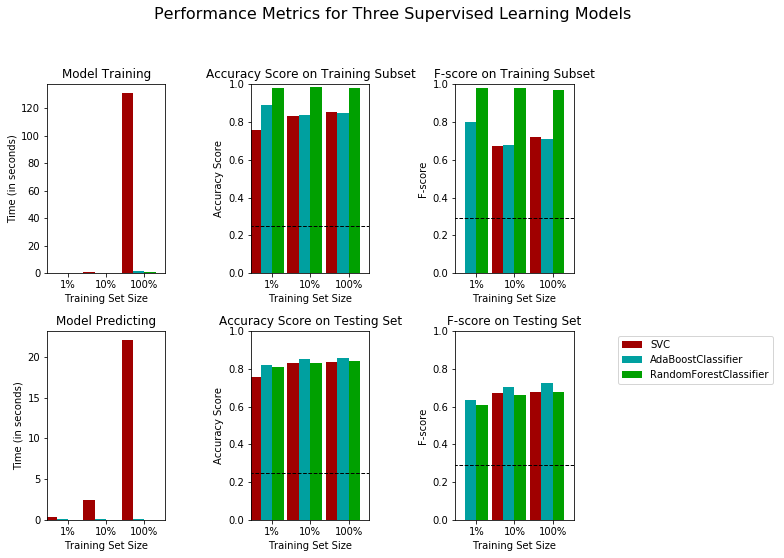

In [101]:
# Visualize the performance of each learner
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom right from the cell above (the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

**Summary of models evaluation:**

|     Model     | F-score     | Training time (s) | Prediction time (s) |
| :-----------: | :---------: |  ---------------: |  -----------------: | 
| SVM           | 0.6745      | 130.93            | 22.10               |
| **AdaBoost**  | **0.7246**  | **1.44**          | **0.06**            |
| Random Forest | 0.6762      | 0.58              | 0.03                |


AdaBoost appears to be the best model for identifying individuals that make more than $50,000 because it has the highest F-score: 0.72 compared to 0.67 for the other two models. Similar to Random Forest, it is fast to train, needing only ~1.5s to fit to the entire training set. As for its prediction time, it is under 100ms and it is small enough to allow CharityML to use it in a real-time setting, if needed. These results confirm that AdaBoost is capable of producing a good binary classification model for problems with skewed distribution of classes.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.
* When explaining your model, if using external resources please include all citations.

**Answer: ** 

AdaBoost is an algorithm that combines multiple weak models into a strong one. It consists of two phases: one to train the weak models and another one to combine them. The first phase consists in training a series of models such that each model tries to fix the mistakes of the previous model. In other words, each model pays more attention to the incorrect predictions of the previous model. Depending on how accurate it is, each model is assigned a score that indicates its performance (the more accurate the model is, the higher its score). Finally, after all weak models are trained, the algorithm makes a prediction by taking into account all the predictions of the weak models and giving more importance to those with higher scores.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

clf = AdaBoostClassifier(random_state=14)
params = {
    'n_estimators': [25, 50, 100, 250, 500, 1000],
    'learning_rate': [0.25, 0.5, 1.0]
}
scorer = make_scorer(fbeta_score, beta=0.5)

# Fit the grid search object to the training data
# to find the optimal parameters
grid_obj = GridSearchCV(clf, params, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_

# Compare the performance of the unoptimized and optimized models
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print('Unoptimized model (n_estimators=50, learning_rate=1.0)')
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('F-score:  {:.4f}'.format(fbeta_score(y_test, predictions, beta = 0.5)))

print('\nOptimized Model (n_estimators={}, learning_rate={})'
      .format(best_clf.n_estimators, best_clf.learning_rate))
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, best_predictions)))
print('F-score:  {:.4f}'.format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model (n_estimators=50, learning_rate=1.0)
Accuracy: 0.8576
F-score:  0.7246

Optimized Model (n_estimators=1000, learning_rate=1.0)
Accuracy: 0.8676
F-score:  0.7448


### AdaBoost performance vs. maximum number of estimators

An analysis of AdaBoostClassifier's performance in relation to the maximum number of estimators

In [176]:
scores = []
train_times = []
prediction_times = []
max_estimators = [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

for n in max_estimators:
    print('Training with {:6,d} maximum estimators... '.format(n), end='')
    
    clf = AdaBoostClassifier(n_estimators=n, random_state=14)
    
    train_start = time()
    clf.fit(X_train, y_train)
    train_times.append(time()-train_start)
    
    pred_start = time()
    predictions = clf.predict(X_test)
    prediction_times.append(time()-pred_start)
    
    score = fbeta_score(y_test, predictions, beta=0.5)
    scores.append(score)
    
    print('DONE! (F-score: {:.4f}; Train: {:3.2f}s; Predict: {:.2f}s)'
          .format(scores[-1], train_times[-1], prediction_times[-1]))

Training with     10 maximum estimators... DONE! (F-score: 0.7107; Train: 0.44s; Predict: 0.02s)
Training with     50 maximum estimators... DONE! (F-score: 0.7246; Train: 1.79s; Predict: 0.08s)
Training with    100 maximum estimators... DONE! (F-score: 0.7316; Train: 3.40s; Predict: 0.12s)
Training with    200 maximum estimators... DONE! (F-score: 0.7396; Train: 6.26s; Predict: 0.25s)
Training with    500 maximum estimators... DONE! (F-score: 0.7432; Train: 15.35s; Predict: 0.61s)
Training with  1,000 maximum estimators... DONE! (F-score: 0.7448; Train: 31.14s; Predict: 1.19s)
Training with  2,000 maximum estimators... DONE! (F-score: 0.7482; Train: 61.57s; Predict: 2.69s)
Training with  5,000 maximum estimators... DONE! (F-score: 0.7479; Train: 153.34s; Predict: 5.87s)
Training with 10,000 maximum estimators... DONE! (F-score: 0.7493; Train: 304.20s; Predict: 11.86s)


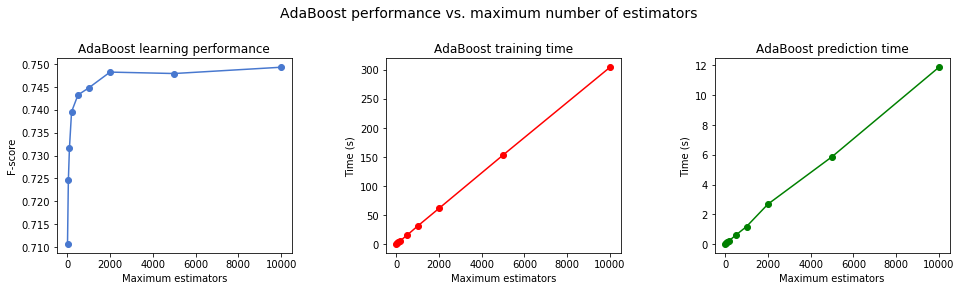

In [178]:
fig = plt.figure(figsize=(16, 4))
fig.suptitle('AdaBoost performance vs. maximum number of estimators', fontsize=14)

ax1 = fig.add_subplot(131)
ax1.set_title('AdaBoost learning performance')
ax1.plot(max_estimators, scores, 'o-')
ax1.set_xlabel('Maximum estimators')
ax1.set_ylabel('F-score')

ax2 = fig.add_subplot(132)
ax2.set_title('AdaBoost training time')
ax2.plot(max_estimators, train_times, 'o-', color='r')
ax2.set_xlabel('Maximum estimators')
ax2.set_ylabel('Time (s)')

ax3 = fig.add_subplot(133)
ax3.set_title('AdaBoost prediction time')
ax3.plot(max_estimators, prediction_times, 'o-', color='g')
ax3.set_xlabel('Maximum estimators')
ax3.set_ylabel('Time (s)')

plt.subplots_adjust(top=0.8, wspace=0.4)
plt.show()

**Quick notes:**
- It appears that AdaBoost's performance increases asymptotically towards 0.75.
- The performance gain of an ensemble with 10,000 estimators over one with 2,000 estimators is 0.1%.
- Both training and prediction times have a linear relationship with the number of estimators.

### What's inside a boosted ensemble?

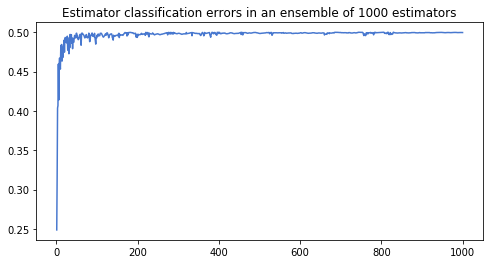

In [175]:
clf_1000 = AdaBoostClassifier(n_estimators=1000, random_state=14)
clf_1000.fit(X_train, y_train)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, 1001), clf_1000.estimator_errors_)
plt.title('Estimator classification errors in an ensemble of 1000 estimators')
plt.show()

### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?

#### Results:

|     Metric     | Unoptimized Model | Optimized Model<br>(1000 estimators) | Naive predictor |
| :------------: | :---------------: | :-------------: | :-------------: |
| Accuracy Score | 0.8576            | **0.8676**          | 0.2478          |
| F-score        | 0.7246            | **0.7448**          | 0.2917          |

**Answer:**

The optimized model managed to improve both the accuracy and the F-score of the unoptimized model. Particularly, its F-score is 2% greater than the one of the basic model (0.7448 compared to 0.7246). As far as comparing it to the naive predictor, the optimized model's F-score is 2.5 times greater, which means it is definitely performing well.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is almost always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

In my opinion, the most important features for predicting an individual's income are:
1. **occupation** &rarr; The average salary varies greatly between occupations and it might be a great indicator for an individual's annual salary. For example, the average annual salary of an engineer is greater than a farmer's one.
2. **capital_gain** &rarr; It's a direct measure of an individual's monetary gains.
3. **education_level** &rarr; Individuals with higher levels of education have access to more opportunities and better paying jobs.
4. **workclass** &rarr; Usually, individuals working in the private sector earn more than the ones working for the state.
5. **age** &rarr; The older an individual is, the more time he has had to gain experience and improve his skills. This should translate in career advancements and multiple salary raises over the years.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

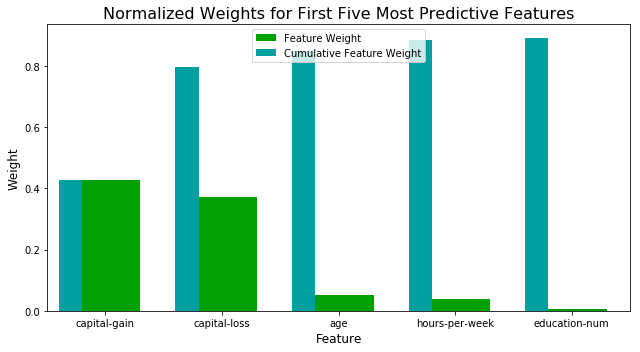

In [14]:
model = AdaBoostClassifier(n_estimators=1000, random_state=14)
model.fit(X_train, y_train)
importances = model.feature_importances_

# Plot the feature importances
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

The visualization confirms the importance of the **capital_gain** and **age** features. I should have assumed that **capital_loss** is also important since it's another direct measure of an individual's capital.
I'm surprised that **occupation** is not among the most important features. It's probably more important if you work extra hours than if you have an occupation with a high base salary. So, **hours_per_week** is more important because you earn much more money if you consistently work overtime. Regarding **education_num**, it is probably similar to **education_level** in that it reflects an individual's education level.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [20]:
from sklearn.base import clone

# Reduce the feature space to the 5 most important features
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Fit a model to the reduced feature space using the
# parameters of the optimized model found with grid seach
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
reduced_predictions = clf.predict(X_test_reduced)

print('Optimized model trained on all features')
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, best_predictions)))
print('F-score:  {:.4f}'.format(fbeta_score(y_test, best_predictions, beta = 0.5)))

print('\nOptimized model trained on top 5 most important features')
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, reduced_predictions)))
print('F-score:  {:.4f}'.format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Optimized model trained on all features
Accuracy: 0.8676
F-score:  0.7448

Optimized model trained on top 5 most important features
Accuracy: 0.8433
F-score:  0.7053


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

Fitting to the top 5 most important features results in a model with 0.8433 accuracy and an F-score of 0.7053. In comparison to the optimized model trained on all features, this means the reduced feature space leads to a 4% decrease in the F-score and a 2.3% decrease in accuracy.

In case training time was more important than building a model with a higher performance, then the reduced feature space could be used because it offers a decent performance. An F-score of 0.7 might be good enough for CharityML to identify individuals making more than $50,000. 
Personally, I would be willing to spend more time on training a better model because it would make better predictions and it would most likely lead to increased revenue in the long run. It would increase CharityML's chances of identifying individuals willing to make donations and it would decrease their chances of wasting resources on going after individuals with low incomes.

### AdaBoost training time vs. number of features

An analysis of AdaBoostClassifier's training time in relation to the number of features

In [24]:
scores = []
train_times = []
prediction_times = []
n_features = [10, 20, 50, 103]

for n in n_features:
    print('Training with {:3d} features... '.format(n), end='')
    
    X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:n]]]
    X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:n]]]

    clf = AdaBoostClassifier(n_estimators=1000, random_state=14)
    
    train_start = time()
    clf.fit(X_train_reduced, y_train)
    train_times.append(time()-train_start)
    
    pred_start = time()
    predictions = clf.predict(X_test_reduced)
    prediction_times.append(time()-pred_start)
    
    score = fbeta_score(y_test, predictions, beta=0.5)
    scores.append(score)
    
    print('DONE! (F-score: {:.4f}; Train: {:3.2f}s; Predict: {:.2f}s)'
          .format(scores[-1], train_times[-1], prediction_times[-1]))

Training with  10 features... DONE! (F-score: 0.7194; Train: 11.64s; Predict: 0.82s)
Training with  20 features... DONE! (F-score: 0.7347; Train: 13.23s; Predict: 0.75s)
Training with  50 features... DONE! (F-score: 0.7449; Train: 19.70s; Predict: 0.93s)
Training with 103 features... DONE! (F-score: 0.7448; Train: 28.37s; Predict: 1.04s)


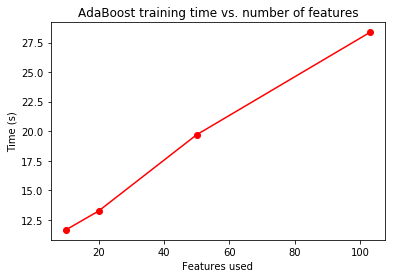

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('AdaBoost training time vs. number of features')
ax.plot(n_features, train_times, 'o-', color='r')
ax.set_xlabel('Features used')
ax.set_ylabel('Time (s)')

plt.show()

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.